#Newton's Method

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.optimize as sopt
import sklearn.datasets
import time

In [10]:
def newton( func, initial_x, H=None, b=None, eps=1e-5, maximum_iterations=65536, linesearch=None):
    """ 
    Newton's Method
    func:               the function to optimize It is called as "value, gradient, hessian = func( x, 2 )
    initial_x:          the starting point
    eps:                the maximum allowed error in the resulting stepsize t
    maximum_iterations: the maximum allowed number of iterations
    linesearch:         the linesearch routine. Bisection recommended for 1 variable, backtracking recommended for 2 or more variables
    """

    if eps <= 0:
        raise ValueError("Epsilon must be positive")
    x = np.asarray( initial_x.copy() )
    n = len(x)

    #Initialization
    values = []
    runtimes = []
    xs = []
    start_time = time.time()
    iterations = 0

    #Newton's method updates
    while True:

        if H is None:
          value, gradient, hessian = func( x , order=2 )
          value = np.double( value )
          gradient = np.matrix( gradient )
          hessian = np.matrix( hessian ) 
        
        else:
          value, gradient, hessian = func( H, b, x, order=2)
          value = np.double( value )
          gradient = np.matrix( gradient )
          gradient = gradient.reshape(n, 1)
          hessian = np.matrix( hessian ) 

        #Updating the logs
        values.append( value )
        runtimes.append( time.time() - start_time )
        xs.append( x.copy() )

        #Newton update direction
        direction = -1*np.linalg.inv(hessian)*gradient

        #Newton decrement
        newton_decrement = np.double(gradient.T*np.linalg.inv(hessian)*gradient)

        #Termination Criteria
        if abs(newton_decrement/2) <= eps:
            break

        if linesearch is None:
          t = 1
        else:
          if H is None:
            t = linesearch(func, x, direction)
          else:
            t = linesearch(func, x, direction, H, b)

        #Update x
        x = x + (t*direction.T)

        iterations += 1
        if iterations >= maximum_iterations:
            return direction
            raise ValueError("Too many iterations")

    return (x, values, runtimes, xs)

In [6]:
#Newton Method for quadratic function
def quadratic(H, b, x, order=0):
    """ 
    Quadratic function
    H:              the hessian
    b:              the gradient
    x:              the point to evaluate the function
    order:          Value = 0, gradient = 1, hessian = 2
    """
    H = np.asmatrix(H)
    b = np.asmatrix(b)
    x = np.asmatrix(x)

    value = 0.5 * x * H * x.T + x * b.T
    if order == 0:
        return value
    elif order == 1:
        gradient = x * H + b
        return (value, gradient)
    elif order == 2:
        gradient = x * H + b
        hessian = H
        return (value, gradient, hessian)
    else:
        raise ValueError("The argument \"order\" should be 0, 1 or 2")

In [5]:
#Exact Line Search (Bisection)
def bisection(func, x, direction, eps=1e-3):
    """ 
    Bisection Method
    func:               the function to optimize It is called as "value, gradient, hessian = func( x, 2 )
    x:                  the point to evaluate the function
    direction:          the direction to evaluate
    eps:                the maximum allowed error in the resulting stepsize t
    """
    a = 0
    b = 1
    c = (b+a)/2
    error = abs(b-a)
    count = 0
    def f(t):
      value, grad = func(x + (t*direction), 1)
      return abs(grad)

    while error > eps:
      if f(a) < f(b):
        b = c 
        error = abs(b-a)
      else:
        a = c
        error = abs(b-a)
      c_old = c
      c = (b+a)/2
      dif = abs(c - c_old)
      if dif < eps:
        return c
      count += 1
    return c

In [7]:
#Backtracking line search
def backtracking(func, x, direction, iterations=10, H = None, b = None, eps = 1e-5):
    """ 
    Backtracking line search algorithm
    func:               the function to optimize It is called as "value, gradient, hessian = func( x, 2 )
    x:                  the point to evaluate the function
    direction:          the direction to evaluate
    iterations:         the maximum number of iterations
    H:                  the hessian (It applies only for quadratic function)
    b:                  the gradient (It applies only for quadratic function)
    eps:                the maximum allowed error in the resulting stepsize t
    """
    alpha = 0.25
    beta = 0.5
    count = 0
    t = 1
    n = len(direction)
    approx = -float('inf')
    if H is None:
      #print(func(x + t*direction))
      while func(x + t*direction.T, order = 0) >= approx and count <= iterations:
          val,grad = func(x, order = 1)
          approx = val + alpha*t*grad.T*direction
          t = t*beta
          count += 1
      return t 
    else: 
      test = func(H, b, x + t*direction.T, order = 0)
      while func(H, b, x + t*direction.T, order = 0) >= approx and count <= iterations:
          val,grad = func(H, b, x, order = 1)
          grad = grad.reshape(n, 1)
          approx = val + alpha*t*grad.T*direction
          t = t*beta
          count += 1
      return t 

#Examples

In [13]:
#Function example
def first_example_func(x, order=0):
  x=np.asmatrix(x).T
  value = x**4 + 16*x**2 + 18*(x-4)*np.exp(x)
  if order==0:
    return value
  elif order == 1:
    gradient = 4*x*(x**2 + 8) + (18*(np.exp(x)*(x-3)))
    return (value, gradient)
  elif order ==2:
    gradient = 4*x*(x**2 + 8) + (18*(np.exp(x)*(x-3)))
    hessian = 2*(6*x**2 + (9*np.exp(x)*(x-2)) + 16)
    return (value, gradient, hessian)
  else:
    raise ValueError("The argument \"order\" should be 0, 1 or 2")

Optimal x after 30 iterations is [[2.32232611]]
Optimal point found in [[-192.62418183]]
Solved in 30 steps with t=1
Optimal x after 8 iterations is [[2.32250552]]
Optimal point found in [[-192.62417928]]
Solved in 8 steps with linesearch chosen from <function bisection at 0x7fb4e3c88f80>


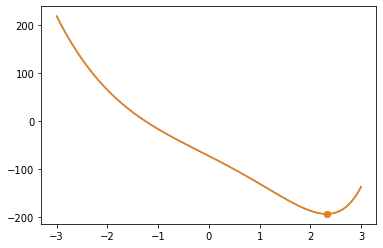

In [14]:
#First function results
tests = [None, bisection]
for test in tests:
  x, values, runtimes, xs = newton(first_example_func, [1], linesearch=test)

  x_hist = []
  for i in range(len(xs)):
    val = xs[i].tolist()
    if i == 0:
      x_hist.append(val[0])
    else:
      x_hist.append(val[0][0])

  def first_func_plot(x):
    return x**4 + 16*x**2 + 18*(x-4)*np.exp(x)

  X = np.linspace(-3, 3, 100)
  plt.plot(X, first_func_plot(X))
  plt.scatter(x_hist[-1], first_func_plot(x_hist[-1]))
  #plt.plot(x_hist, example_func(np.array(x_hist)), marker='o', color='red', ls='--')
  print(f'Optimal x after {len(xs)} iterations is {x}')
  print(f'Optimal point found in {first_func_plot(x)}')
  if test is None:
    print(f'Solved in {len(xs)} steps with t=1')
  else:
    print(f'Solved in {len(xs)} steps with linesearch chosen from {test}')

In [11]:
#Boyd Function
def boyd_example_func(x, order=0):
  a=np.matrix('1  3')
  b=np.matrix('1  -3')
  c=np.matrix('-1  0')
  x=np.asmatrix(x).T

  value = np.exp(a*x-0.1)+np.exp(b*x-0.1)+np.exp(c*x-0.1)
  if order==0:
      return value
  elif order==1:
      gradient = (a.T*np.exp(a*x-0.1)) + (b.T*np.exp(b*x-0.1)) + (c.T*np.exp(c*x-0.1))
      return (value, gradient)
  elif order==2:
      gradient = (a.T*np.exp(a*x-0.1)) + (b.T*np.exp(b*x-0.1)) + (c.T*np.exp(c*x-0.1))
      #hessian = a.T*a + b.T*b + c.T*c
      hessian = a.T*a*np.exp(a*x-0.1).item() + (b.T*b*np.exp(b*x-0.1).item()) + (c.T*c*np.exp(c*x-0.1).item())
      return (value, gradient, hessian)
  else:
        raise ValueError("The argument \"order\" should be 0, 1 or 2")

Optimal x after 16 iterations is [[-3.46570355e-01  2.15710999e-06]]
Optimal point fonund in [[2.5592667]]
Solved in 16 steps with t=1
Optimal x after 33 iterations is [[-0.34504892  0.00101645]]
Optimal point fonund in [[2.55927563]]
Solved in 33 steps with linesearch chosen from backtracking


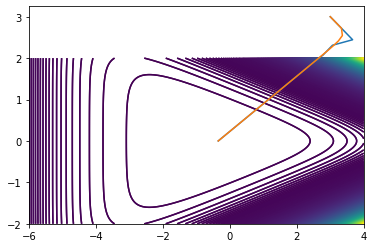

In [12]:
tests = [None, backtracking]
for test in tests:
  x, values, runtimes, xs = newton(boyd_example_func, [3, 3], linesearch=test)

  x_hist = []
  y_hist = []
  for i in range(len(xs)):
    val = xs[i].tolist()
    if i == 0:
      x_hist.append(val[0])
      y_hist.append(val[1])
    else:
      x_hist.append(val[0][0])
      y_hist.append(val[0][1])

  def boyd_func(x):
    a = np.array([1, 3])
    b = np.array([1, -3])
    c = np.array([-1, 0])
    x = np.array(x).T
    value = np.exp(a@x-0.1)+np.exp(b@x-0.1)+np.exp(c@x-0.1)
    return value

  MX, MY = np.meshgrid(np.linspace(-6, 4, 250), np.linspace(-2, 2, 250))
  Z = np.array([MX, MY]).reshape(2, -1)
  VR = boyd_func(Z.T)
  plt.contour(MX, MY, VR.reshape(MX.shape),1000)
  plt.plot(x_hist, y_hist)
  print(f'Optimal x after {len(xs)} iterations is {x}')
  print(f'Optimal point fonund in {boyd_example_func(x)}')
  if test is None:
    print(f'Solved in {len(xs)} steps with t=1')
  else:
    print(f'Solved in {len(xs)} steps with linesearch chosen from backtracking')

In [15]:
#Quadratic Function
H = [[31,3,10],[3,40,5],[2,11,8]]
b = [60,1,9]
x = [1, 2, 3]
x, values, runtimes, xs = newton(quadratic, initial_x = x, H = H, b = b, linesearch=None)
for i in range(len(xs)):
  val = xs[i].tolist()
  if i == 0:
    x_hist.append(val[0])
    y_hist.append(val[1])
  else:
    x_hist.append(val[0][0])
    y_hist.append(val[0][1])
print(f'Optimal x after {len(xs)} iterations is {x}')
print(f'Optimal point fonund in {quadratic(H, b, x)}')

Optimal x after 24 iterations is [[-2.00741012 -0.30768786  1.57554622]]
Optimal point fonund in [[-53.29112951]]
